In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

Read both csv files as dataframes

In [239]:
movies_path = '/content/drive/MyDrive/EDA/Project/data/tmdb_5000_movies.csv'
credits_path = '/content/drive/MyDrive/EDA/Project/data/tmdb_5000_credits.csv'

In [240]:
movies_df = pd.read_csv(movies_path)
credits_df = pd.read_csv(credits_path)

Check column names and types

In [241]:
print(movies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

"Object" refers to string. However, some columns contain simple strings (like sentences) and some columns contain a list of JSONs as a string.

In [242]:
print(credits_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB
None


Take a look at a few examples in both dataframes

In [243]:
movies_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [244]:
credits_df.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


The id column in the movies df seems to have the same values as the movie_id column in the credits df (same for original_title in movies df and title in credits df). Let's check.

In [245]:
id_set = set(movies_df['id'])
print(f"There are {len(id_set)} unique ids in the movies dataframe")
movie_id_set = set(credits_df['movie_id'])
print(f"There are {len(movie_id_set)} unique movie ids in the credits dataframe")

There are 4803 unique ids in the movies dataframe
There are 4803 unique movie ids in the credits dataframe


In [246]:
def are_identical_sets(setA, setB):
  for elem in setA:
    if elem not in setB:
      return False
  for elem in setB:
    if elem not in setA:
      return False
  return True

In [247]:
print(are_identical_sets(id_set, movie_id_set))

True


In [248]:
movies_title_set = set(movies_df['title'])
print(f"There are {len(movies_title_set)} unique titles in the movies dataframe")
original_title_set = set(movies_df['original_title'])
print(f"There are {len(original_title_set)} unique original titles in the movies dataframe")
credits_title_set = set(credits_df['title'])
print(f"There are {len(credits_title_set)} unique titles in the credits dataframe")

There are 4800 unique titles in the movies dataframe
There are 4801 unique original titles in the movies dataframe
There are 4800 unique titles in the credits dataframe


In [249]:
print(are_identical_sets(movies_title_set, credits_title_set))

True


Both datasets contain 4,803 examples but the movies df has 4,800 unique titles (and 4,801 unique original titles) while the credits df has 4,800 unique titles. 
Let's see the rows with duplicated titles in each dataframe.

In [250]:
movies_df[movies_df.duplicated(keep=False, subset=['title'])]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
972,44000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,72710,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,The Host,A parasitic alien soul is injected into the bo...,42.933027,"[{""name"": ""Nick Wechsler Productions"", ""id"": 8...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-03-22,63327201,125.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,You will be one of us,The Host,6.0,1817
1359,35000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",NaN,268,"[{""id"": 848, ""name"": ""double life""}, {""id"": 84...",en,Batman,The Dark Knight of Gotham City begins his war ...,44.104469,"[{""name"": ""PolyGram Filmed Entertainment"", ""id...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1989-06-23,411348924,126.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Have you ever danced with the devil in the pal...,Batman,7.0,2096
2877,11000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 18, ""nam...",http://www.hostmovie.com/,1255,"[{""id"": 1261, ""name"": ""river""}, {""id"": 1880, ""...",ko,괴물,Gang-du is a dim-witted man working at his fat...,27.655270,"[{""name"": ""Cineclick Asia"", ""id"": 685}, {""name...","[{""iso_3166_1"": ""KR"", ""name"": ""South Korea""}]",2006-07-27,88489643,119.0,"[{""iso_639_1"": ""ko"", ""name"": ""\ud55c\uad6d\uc5...",Released,Monsters are real.,The Host,6.7,537
3647,0,"[{""id"": 18, ""name"": ""Drama""}]",NaN,39269,"[{""id"": 4470, ""name"": ""punk""}, {""id"": 10183, ""...",en,Out of the Blue,Dennis Hopper is a hard-drinking truck driver ...,0.679351,"[{""name"": ""Robson Street"", ""id"": 71953}]","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}]",1980-05-01,0,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A harrowing drama from the director of Easy Rider,Out of the Blue,6.5,17
3693,0,"[{""id"": 18, ""name"": ""Drama""}]",NaN,10844,"[{""id"": 2658, ""name"": ""new zealand""}, {""id"": 3...",en,Out of the Blue,Ordinary people find extraordinary courage in ...,0.706355,[],"[{""iso_3166_1"": ""NZ"", ""name"": ""New Zealand""}]",2006-10-12,0,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The true story of a small town massacre,Out of the Blue,5.9,18
4267,1377800,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 12, ""...",NaN,2661,"[{""id"": 339, ""name"": ""submarine""}, {""id"": 849,...",en,Batman,The Dynamic Duo faces four super-villains who ...,9.815394,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1966-07-30,0,105.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He's Here Big As Life In A Real Bat-Epic,Batman,6.1,203


In [251]:
movies_df[movies_df.duplicated(keep=False, subset=['original_title'])]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
1359,35000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",NaN,268,"[{""id"": 848, ""name"": ""double life""}, {""id"": 84...",en,Batman,The Dark Knight of Gotham City begins his war ...,44.104469,"[{""name"": ""PolyGram Filmed Entertainment"", ""id...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1989-06-23,411348924,126.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Have you ever danced with the devil in the pal...,Batman,7.0,2096
3647,0,"[{""id"": 18, ""name"": ""Drama""}]",NaN,39269,"[{""id"": 4470, ""name"": ""punk""}, {""id"": 10183, ""...",en,Out of the Blue,Dennis Hopper is a hard-drinking truck driver ...,0.679351,"[{""name"": ""Robson Street"", ""id"": 71953}]","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}]",1980-05-01,0,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A harrowing drama from the director of Easy Rider,Out of the Blue,6.5,17
3693,0,"[{""id"": 18, ""name"": ""Drama""}]",NaN,10844,"[{""id"": 2658, ""name"": ""new zealand""}, {""id"": 3...",en,Out of the Blue,Ordinary people find extraordinary courage in ...,0.706355,[],"[{""iso_3166_1"": ""NZ"", ""name"": ""New Zealand""}]",2006-10-12,0,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The true story of a small town massacre,Out of the Blue,5.9,18
4267,1377800,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 12, ""...",NaN,2661,"[{""id"": 339, ""name"": ""submarine""}, {""id"": 849,...",en,Batman,The Dynamic Duo faces four super-villains who ...,9.815394,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1966-07-30,0,105.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He's Here Big As Life In A Real Bat-Epic,Batman,6.1,203


In [252]:
credits_df[credits_df.duplicated(keep=False, subset=['title'])]

,movie_id,title,cast,crew
972,72710,The Host,"[{""cast_id"": 52, ""character"": ""Melanie Stryder...","[{""credit_id"": ""52fe487bc3a368484e0fa919"", ""de..."
1359,268,Batman,"[{""cast_id"": 5, ""character"": ""Jack Napier/The ...","[{""credit_id"": ""52fe422fc3a36847f800aa4b"", ""de..."
2877,1255,The Host,"[{""cast_id"": 3, ""character"": ""Park Gang-du"", ""...","[{""credit_id"": ""52fe42eac3a36847f802ca6b"", ""de..."
3647,39269,Out of the Blue,"[{""cast_id"": 2, ""character"": ""Don"", ""credit_id...","[{""credit_id"": ""52fe47099251416c9106826f"", ""de..."
3693,10844,Out of the Blue,"[{""cast_id"": 12, ""character"": ""Nick Harvey"", ""...","[{""credit_id"": ""52fe43c19251416c7501cceb"", ""de..."
4267,2661,Batman,"[{""cast_id"": 17, ""character"": ""Batman / Bruce ...","[{""credit_id"": ""52fe4363c3a36847f80509a7"", ""de..."


It seems they were simply movies with the same title :)
It's interesting to note that even though there are 2 movies with the title 'Host', one of them has the original title written in Korean language.

In [253]:
movies_df[movies_df['id'] == 72710]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
972,44000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,72710,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,The Host,A parasitic alien soul is injected into the bo...,42.933027,"[{""name"": ""Nick Wechsler Productions"", ""id"": 8...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-03-22,63327201,125.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,You will be one of us,The Host,6.0,1817


In [254]:
movies_df[movies_df['id'] == 1255]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2877,11000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 18, ""nam...",http://www.hostmovie.com/,1255,"[{""id"": 1261, ""name"": ""river""}, {""id"": 1880, ""...",ko,괴물,Gang-du is a dim-witted man working at his fat...,27.65527,"[{""name"": ""Cineclick Asia"", ""id"": 685}, {""name...","[{""iso_3166_1"": ""KR"", ""name"": ""South Korea""}]",2006-07-27,88489643,119.0,"[{""iso_639_1"": ""ko"", ""name"": ""\ud55c\uad6d\uc5...",Released,Monsters are real.,The Host,6.7,537


So 'original_title' can be in a language other than english.

Given that the ids match perfectly in both dataframes, we can combine both dfs based on that column (keep a unified name for the column). We can also drop one of 'title' and 'original_title' (the latter, as it can have names in different languages) as we do not need both. Given that there are two 'title' columns (one in each df), we can drop one of them as they are identical (checked above).

In [255]:
credits_df_new = credits_df.rename(columns={'movie_id': 'id'})
credits_df_new.drop(columns=['title'], inplace=True)
df = pd.merge(movies_df, credits_df_new, on='id')
df.drop(columns=['original_title'], inplace=True)
df.head(3)

,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


# Check columns with float values

Some helper functions for checking float value columns

In [256]:
def check_float_column(df, column_name, nan_replacement=-1):
  nanCount = sum(df[column_name].isnull())
  if nanCount > 0:
    print(f"Column has {nanCount} NaN values! Replacing them with {nan_replacement}")
    column = list(df[column_name].fillna(nan_replacement))
  else:
    column = list(df[column_name])
  column_sorted = sorted(column)
  x = [i for i in range(1, len(column) + 1)]
  plt.plot(x, column_sorted)
  plt.xlabel("Movie")
  plt.ylabel(column_name)
  plt.show()

  plt.hist(column_sorted, bins=30)
  plt.show()

  print(df[column_name].describe())

  zero_value = sum(df[column_name] == 0)

  print()
  print(f"There are {zero_value} movies with a value of 0 for {column_name}")

## Check the buget column

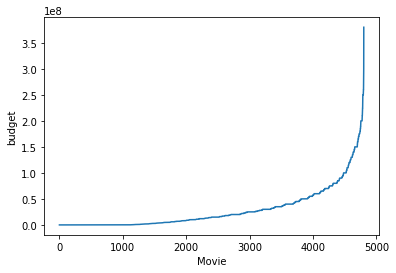

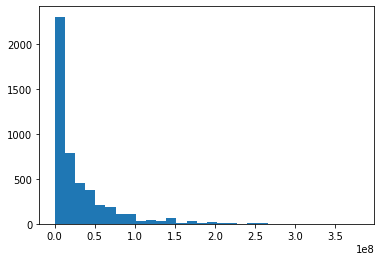

count    4.803000e+03
mean     2.904504e+07
std      4.072239e+07
min      0.000000e+00
25%      7.900000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

There are 1037 movies with a value of 0 for budget


In [257]:
check_float_column(df, "budget")

So more than 1/5 of movies do not have a budget reported.

## Check the popularity column

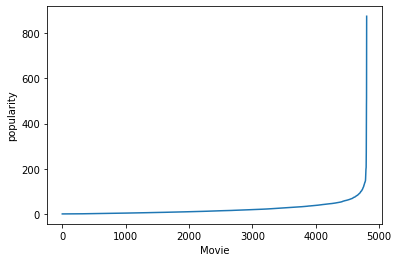

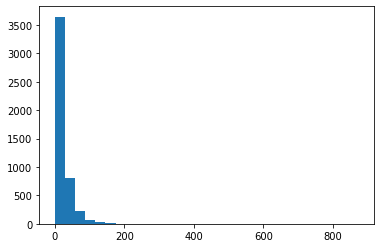

count    4803.000000
mean       21.492301
std        31.816650
min         0.000000
25%         4.668070
50%        12.921594
75%        28.313505
max       875.581305
Name: popularity, dtype: float64

There are 1 movies with a value of 0 for popularity


In [258]:
check_float_column(df, "popularity")

Most movies seem to have low popularity, but there is only one with 0 popularity.

## Check the revenue column

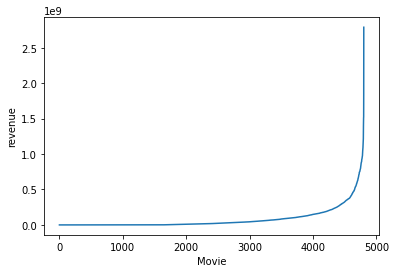

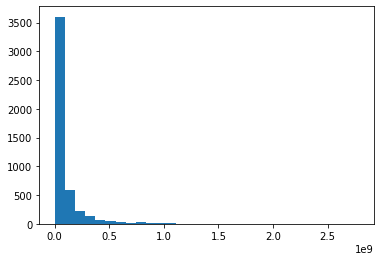

count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: revenue, dtype: float64

There are 1427 movies with a value of 0 for revenue


In [259]:
check_float_column(df, "revenue")

Almost 1/3 of movies have no revenue reported.

## Check the runtime column

Column has 2 NaN values! Replacing them with -1


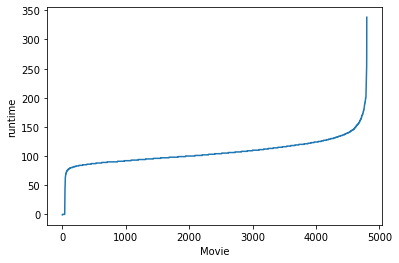

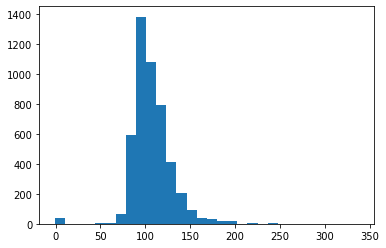

count    4801.000000
mean      106.875859
std        22.611935
min         0.000000
25%        94.000000
50%       103.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

There are 35 movies with a value of 0 for runtime


In [260]:
check_float_column(df, "runtime")

## Check vote_average column

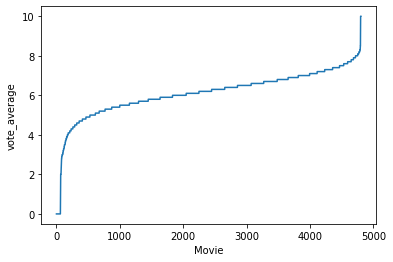

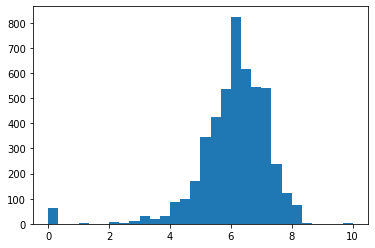

count    4803.000000
mean        6.092172
std         1.194612
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

There are 63 movies with a value of 0 for vote_average


In [261]:
check_float_column(df, "vote_average")

## Check the vote_count column

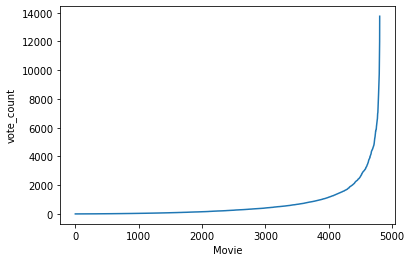

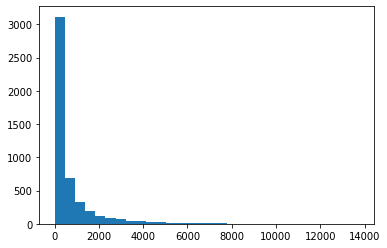

count     4803.000000
mean       690.217989
std       1234.585891
min          0.000000
25%         54.000000
50%        235.000000
75%        737.000000
max      13752.000000
Name: vote_count, dtype: float64

There are 62 movies with a value of 0 for vote_count


In [262]:
check_float_column(df, "vote_count")

# Check string type columns

Some helper functions used to check string columns

In [263]:
def get_unique_strings(df, column_name, nan_replacement="Unknown"):
  nanCount = sum(df[column_name].isnull())
  if nanCount > 0:
    print(f"Column has {nanCount} NaN values! Replacing them with {nan_replacement}")
    column = list(df[column_name].fillna(nan_replacement))
  else:
    column = list(df[column_name])
  uniqueMap = {}
  for elem in column:
    if elem not in uniqueMap:
      uniqueMap[elem] = 1
    else:
      uniqueMap[elem] += 1
  return uniqueMap

In [264]:
def sort_unique_strings(uniqueMap, ascending=False):
  uniqueList = [(key, value) for key, value in uniqueMap.items()]
  if ascending:
    uniqueList.sort(key=lambda x: x[1])
  else:
    uniqueList.sort(key=lambda x: -x[1])
  return uniqueList

In [265]:
def plot_unique_strings(uniqueList, figsize=(6.4, 4.8), title="", xlabel="", ylabel=""):
  dictDummy = {}
  if type(uniqueList) == type(dictDummy):
    raise Exception("uniqueList is a dictionary. It should be a list of tuples of (string, frequency)!")
  strings = [x[0] for x in uniqueList]
  frequencies = [x[1] for x in uniqueList]
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0,0,1,1])
  ax.bar(strings, frequencies)
  if title != "":
    ax.set_title(title)
  if xlabel != "":
    ax.set_xlabel(xlabel)
  if ylabel != "":
    ax.set_ylabel(ylabel)
  plt.show()

## Check original_language column

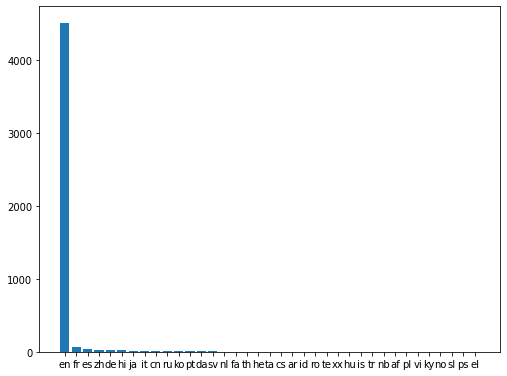

[('en', 4505), ('fr', 70), ('es', 32), ('zh', 27), ('de', 27), ('hi', 19), ('ja', 16), ('it', 14), ('cn', 12), ('ru', 11), ('ko', 11), ('pt', 9), ('da', 7), ('sv', 5), ('nl', 4), ('fa', 4), ('th', 3), ('he', 3), ('ta', 2), ('cs', 2), ('ar', 2), ('id', 2), ('ro', 2), ('te', 1), ('xx', 1), ('hu', 1), ('is', 1), ('tr', 1), ('nb', 1), ('af', 1), ('pl', 1), ('vi', 1), ('ky', 1), ('no', 1), ('sl', 1), ('ps', 1), ('el', 1)]
4803


In [286]:
uniqueLanguage = get_unique_strings(df, "original_language")
uniqueLanguage = sort_unique_strings(uniqueLanguage, ascending=False)
plot_unique_strings(uniqueLanguage)
print(uniqueLanguage)
print(sum([x[1] for x in uniqueLanguage]))

## Check the status column

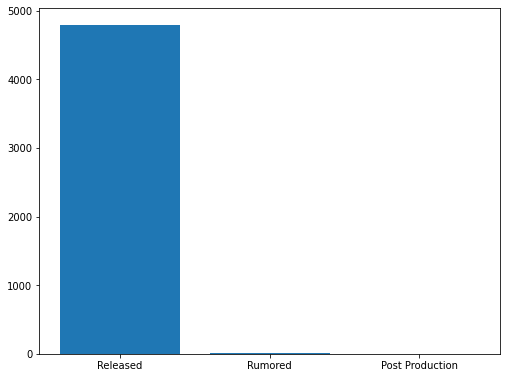

[('Released', 4795), ('Rumored', 5), ('Post Production', 3)]


In [267]:
uniqueStatus = get_unique_strings(df, "status")
uniqueStatus = sort_unique_strings(uniqueStatus, ascending=False)
plot_unique_strings(uniqueStatus)
print(uniqueStatus)

# Check object type (JSON) columns

In [268]:
def check_object_column(df, column_name, key_name, nan_replacement=[], figsize=(6.4, 4.8), ascending=False, bins=10, printCount=20):
  nanCount = sum(df[column_name].isnull())
  if nanCount > 0:
    print(f"Column has {nanCount} NaN values! Replacing them with {nan_replacement}")
    column = list(df[column_name].fillna(nan_replacement))
  else:
    column = list(df[column_name])
  
  # key is a unique string, value is it's frequency in the whole dataset
  columnKeyMap = {}

  # How many dictionary elements are in the current column for each example in the df
  # E.g. how many genres each movie has
  elementsInObject = []

  for jsonString in column:
    dictionaryList = json.loads(jsonString)
    elementsInObject.append(len(dictionaryList))
    for dictionary in dictionaryList:
      key = dictionary[key_name]
      if key in columnKeyMap:
        columnKeyMap[key] += 1
      else:
        columnKeyMap[key] = 1

  columnKeyList = sort_unique_strings(columnKeyMap, ascending=False)
  
  print(f"Found {len(columnKeyList)} different unique elements")
  if printCount == -1 or len(columnKeyList) <= printCount:
    print(columnKeyList)
  else:
    print("First elements:")
    print(columnKeyList[:printCount])
    print("Last elements:")
    print(columnKeyList[-printCount:])

  if len(columnKeyList) <= 30:
    title = f"Movie count per unique value in {column_name}"
    xlabel = column_name
    ylabel = "Movie count"
    plot_unique_strings(columnKeyList, figsize, title=title, xlabel=xlabel, ylabel=ylabel)
  else:
    elementsInObjectSorted = sorted(elementsInObject)
    x = [i for i in range(1, len(elementsInObject) + 1)]
    plt.plot(x, elementsInObjectSorted)
    plt.xlabel("Movie")
    plt.ylabel(f"Number of elements in {column_name}")
    plt.show()


  plt.hist(elementsInObject, bins=bins)
  plt.title(f"{column_name} count per movie")
  plt.xlabel(f"{column_name} count")
  plt.ylabel("Movie count")
  plt.show()

  zero_value = sum([1 for elem in elementsInObject if elem == 0])

  print()
  print(f"There are {zero_value} movies with no elements in {column_name}")


## Check genres column

Found 20 different unique elements
[('Drama', 2297), ('Comedy', 1722), ('Thriller', 1274), ('Action', 1154), ('Romance', 894), ('Adventure', 790), ('Crime', 696), ('Science Fiction', 535), ('Horror', 519), ('Family', 513), ('Fantasy', 424), ('Mystery', 348), ('Animation', 234), ('History', 197), ('Music', 185), ('War', 144), ('Documentary', 110), ('Western', 82), ('Foreign', 34), ('TV Movie', 8)]


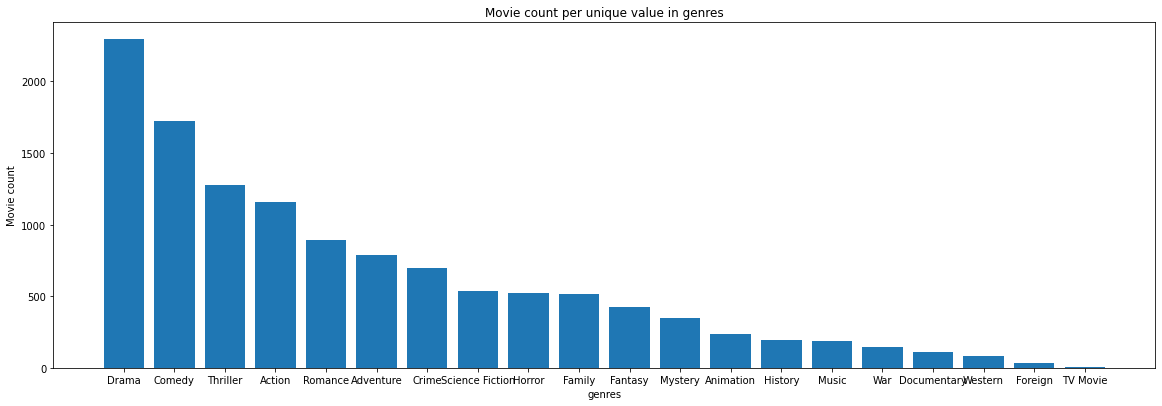

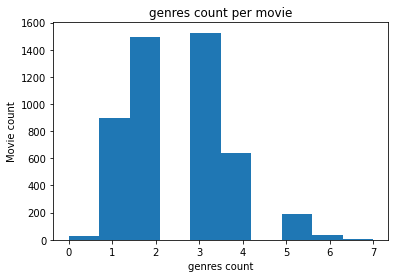


There are 28 movies with no elements in genres


In [269]:
check_object_column(df, "genres", "name", figsize=(15.3, 4.8))

## Check keywords column

Found 9813 different unique elements
First elements:
[('woman director', 324), ('independent film', 318), ('duringcreditsstinger', 307), ('based on novel', 197), ('murder', 189), ('aftercreditsstinger', 170), ('violence', 150), ('dystopia', 139), ('sport', 126), ('revenge', 118), ('sex', 111), ('friendship', 106), ('musical', 105), ('biography', 105), ('teenager', 99), ('3d', 98), ('love', 95), ('sequel', 94), ('suspense', 92), ('new york', 89)]
Last elements:
[('pap smear', 1), ('austin texas', 1), ('reference to jack ruby', 1), ('dairy queen restaurant', 1), ('moon walk', 1), ('anti romantic comedy', 1), ('excrements ', 1), ('adult humor', 1), ('estranged son', 1), ('psychosis', 1), ('personality disorder', 1), ('serial kiler', 1), ('latino lgbt', 1), ('gang initiation', 1), ('gunplay', 1), ('homeless', 1), ('arms', 1), ('paper knife', 1), ('guitar case', 1), ('postal worker', 1)]


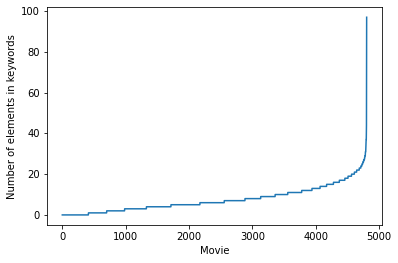

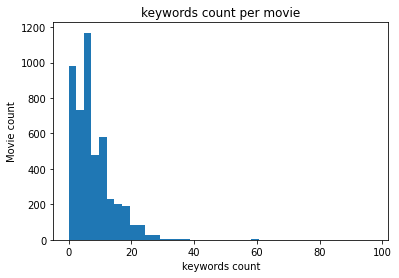


There are 412 movies with no elements in keywords


In [270]:
check_object_column(df, "keywords", "name", figsize=(15.3, 4.8), bins=40)

## Check production_companies	column


Found 5017 different unique elements
First elements:
[('Warner Bros.', 319), ('Universal Pictures', 311), ('Paramount Pictures', 285), ('Twentieth Century Fox Film Corporation', 222), ('Columbia Pictures', 201), ('New Line Cinema', 165), ('Metro-Goldwyn-Mayer (MGM)', 122), ('Touchstone Pictures', 118), ('Walt Disney Pictures', 114), ('Relativity Media', 102), ('Columbia Pictures Corporation', 96), ('Miramax Films', 94), ('Village Roadshow Pictures', 81), ('DreamWorks SKG', 79), ('Canal+', 75), ('United Artists', 75), ('Regency Enterprises', 69), ('Fox Searchlight Pictures', 64), ('Dune Entertainment', 59), ('Lionsgate', 56)]
Last elements:
[('Amok Productions', 1), ('GO Productions', 1), ('Vicarious Entertainment', 1), ('Bloodline Productions', 1), ('Shallow Focus', 1), ('Grindfest', 1), ('Dreamland Productions', 1), ('Jafar Panahi Film Productions', 1), ('Park Films', 1), ('Camera Stylo Films', 1), ('Daiei Studios', 1), ('Iconoclast Films', 1), ('Gold Lion Films', 1), ('T-Street Produ

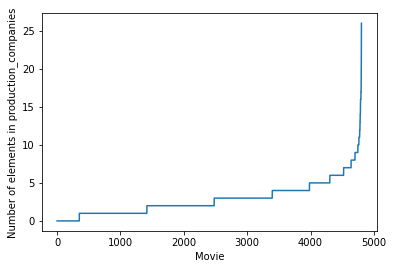

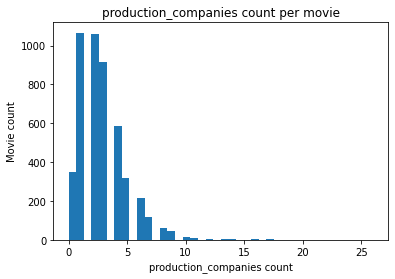


There are 351 movies with no elements in production_companies


In [271]:
check_object_column(df, "production_companies", "name", figsize=(15.3, 4.8), bins=40)

## Check production_countries column

Found 88 different unique elements
First elements:
[('US', 3956), ('GB', 636), ('DE', 324), ('FR', 306), ('CA', 261), ('AU', 110), ('IT', 72), ('ES', 71), ('CN', 59), ('JP', 58), ('IN', 54), ('HK', 48), ('IE', 37), ('MX', 30), ('NZ', 28), ('BE', 25), ('CZ', 24), ('ZA', 20), ('DK', 20), ('SE', 19)]
Last elements:
[('CS', 1), ('TR', 1), ('NG', 1), ('CY', 1), ('JO', 1), ('BO', 1), ('EC', 1), ('EG', 1), ('BT', 1), ('LB', 1), ('KG', 1), ('DZ', 1), ('ID', 1), ('GY', 1), ('GP', 1), ('AF', 1), ('AO', 1), ('DO', 1), ('CM', 1), ('KE', 1)]


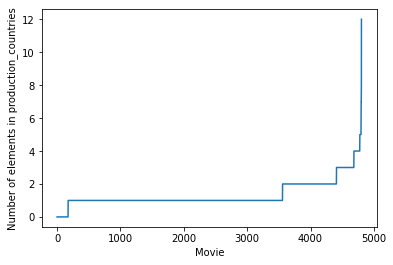

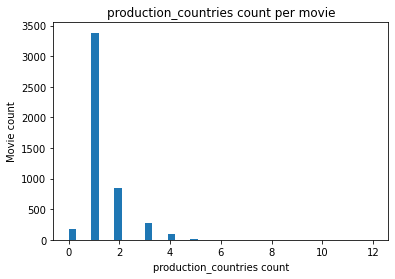


There are 174 movies with no elements in production_countries


In [272]:
check_object_column(df, "production_countries", "iso_3166_1", figsize=(15.3, 4.8), bins=40)

## Check spoken_languages column

Found 87 different unique elements
First elements:
[('en', 4485), ('fr', 437), ('es', 351), ('de', 262), ('it', 188), ('ru', 185), ('zh', 107), ('ja', 97), ('pt', 68), ('ar', 67), ('pl', 53), ('la', 52), ('hi', 48), ('cn', 48), ('hu', 42), ('th', 40), ('cs', 38), ('he', 33), ('ko', 31), ('sv', 22)]
Last elements:
[('tl', 1), ('te', 1), ('iu', 1), ('wo', 1), ('ny', 1), ('st', 1), ('kw', 1), ('si', 1), ('ne', 1), ('gl', 1), ('ka', 1), ('bn', 1), ('ku', 1), ('to', 1), ('ca', 1), ('br', 1), ('dz', 1), ('ky', 1), ('bm', 1), ('sl', 1)]


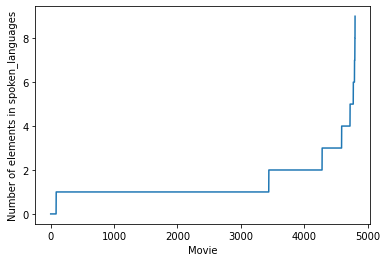

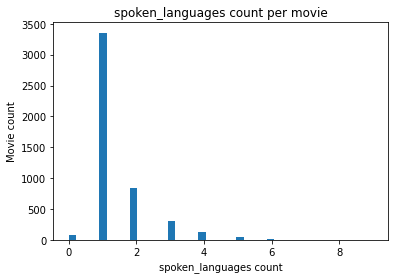


There are 86 movies with no elements in spoken_languages


In [273]:
check_object_column(df, "spoken_languages", "iso_639_1", figsize=(15.3, 4.8), bins=40)

## Check cast column

Check actors

Found 54201 different unique elements
First elements:
[('Samuel L. Jackson', 67), ('Robert De Niro', 57), ('Bruce Willis', 51), ('Matt Damon', 48), ('Morgan Freeman', 46), ('Steve Buscemi', 43), ('Liam Neeson', 41), ('Johnny Depp', 40), ('Owen Wilson', 40), ('John Goodman', 39), ('Nicolas Cage', 39), ('Alec Baldwin', 39), ('Willem Dafoe', 38), ('Jim Broadbent', 38), ('Stanley Tucci', 38), ('Brad Pitt', 38), ('Paul Giamatti', 37), ('Will Ferrell', 37), ('Richard Jenkins', 36), ('Susan Sarandon', 36)]
Last elements:
[('Ashley Warren', 1), ('Samantha Thomson', 1), ('Chip Carruth', 1), ('Delaney Price', 1), ('Jack Pyland', 1), ('Keith Bradshaw', 1), ('Ashok Upadhyaya', 1), ('Brandon Blagg', 1), ('Jon Cook', 1), ('David Joyner', 1), ('Eric De Soualhat', 1), ('Jaime de Hoyos', 1), ('Reinol Martinez', 1), ('Ramiro Gomez', 1), ('Consuelo Gómez', 1), ('Daniella Pineda', 1), ('Laci J Mailey', 1), ('Zhu Shimao', 1), ('Brian Herzlinger', 1), ("Bill D'Elia", 1)]


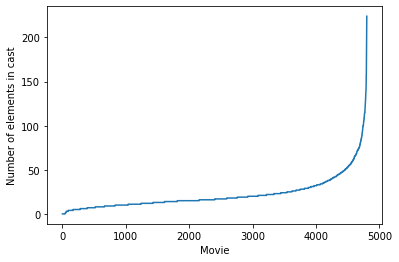

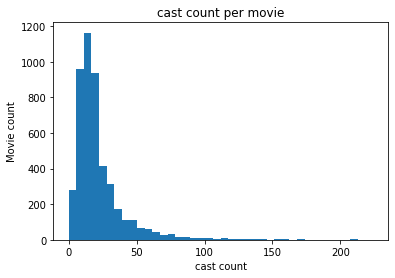


There are 43 movies with no elements in cast


In [274]:
check_object_column(df, "cast", "name", figsize=(15.3, 4.8), bins=40)

Check characters

Found 71577 different unique elements
First elements:
[('Himself', 909), ('', 683), ('Dancer', 375), ('Additional Voices (voice)', 323), ('Herself', 229), ('Reporter', 136), ('Doctor', 132), ('Nurse', 117), ('Waitress', 108), ('Bartender', 93), ('Extra: Bar / Comedy Club', 85), ('Cop', 81), ('Paul', 81), ('Student', 80), ('Security Guard', 78), ('Sam', 78), ('(voice)', 77), ('Jack', 72), ('Frank', 70), ('Choir', 69)]
Last elements:
[('Man On Couch #1', 1), ('Man On Couch #2', 1), ('Rachel Granger', 1), ('Thomas Granger', 1), ("Aaron's Co-worker", 1), ('Clean Room Technician', 1), ("Will's Cousin", 1), ("Rachel's Date", 1), ('Bigotón', 1), ('Mauricio (Moco)', 1), ('Azul', 1), ('Cantinero', 1), ("Moco's Men", 1), ('Oliver O’Toole', 1), ('Shane McInerney', 1), ('Rita Haywith', 1), ('Norman Dorman', 1), ('Charlie Riggs', 1), ('Andrea Shmeckle', 1), ('Marcus Groff', 1)]


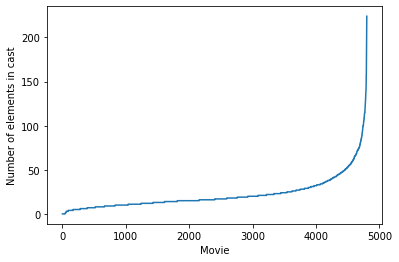

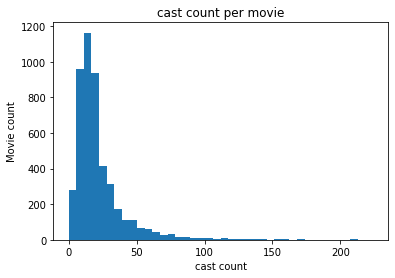


There are 43 movies with no elements in cast


In [275]:
check_object_column(df, "cast", "character", figsize=(15.3, 4.8), bins=40)

Check actor genders

Found 3 different unique elements
[(2, 48291), (0, 33798), (1, 24168)]


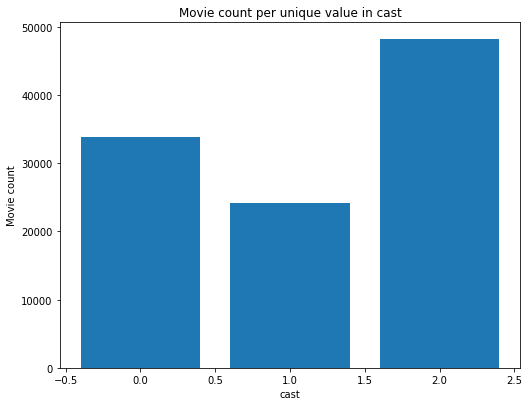

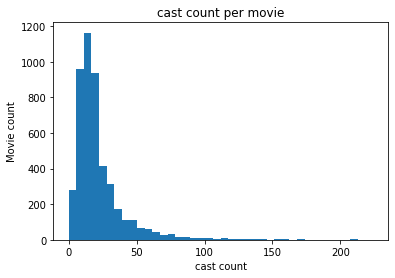


There are 43 movies with no elements in cast


In [276]:
check_object_column(df, "cast", "gender", figsize=(6.4, 4.8), bins=40)

## Check crew column

Check crew department

Found 12 different unique elements
[('Production', 27675), ('Sound', 16176), ('Art', 14853), ('Crew', 13826), ('Costume & Make-Up', 11188), ('Writing', 10688), ('Camera', 9204), ('Directing', 8149), ('Editing', 7855), ('Visual Effects', 7553), ('Lighting', 2410), ('Actors', 4)]


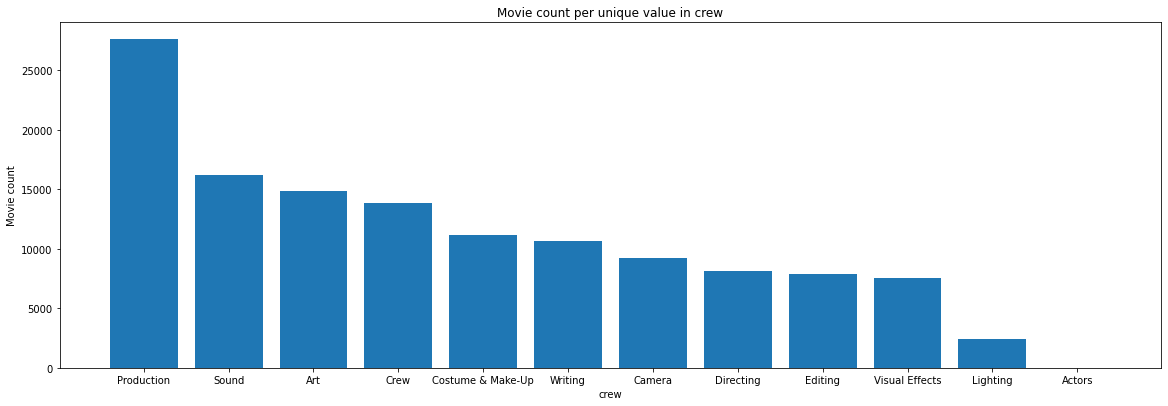

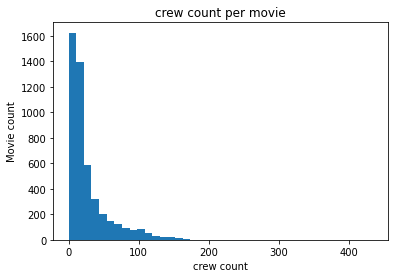


There are 28 movies with no elements in crew


In [277]:
check_object_column(df, "crew", "department", figsize=(15.3, 4.8), bins=40)

Check crew job

Found 418 different unique elements
First elements:
[('Producer', 10206), ('Executive Producer', 6177), ('Director', 5166), ('Screenplay', 5010), ('Editor', 4699), ('Casting', 4447), ('Director of Photography', 3676), ('Art Direction', 3338), ('Original Music Composer', 3154), ('Production Design', 2837), ('Costume Design', 2670), ('Writer', 2348), ('Set Decoration', 2283), ('Makeup Artist', 1977), ('Animation', 1736), ('Script Supervisor', 1708), ('Sound Re-Recording Mixer', 1694), ('Camera Operator', 1645), ('Visual Effects Supervisor', 1601), ('Hairstylist', 1511)]
Last elements:
[('Lighting Production Assistant', 1), ('Armory Coordinator', 1), ('Story Editor', 1), ('Prop Designer', 1), ('Schedule Coordinator', 1), ('Special Guest Director', 1), ('Set Production Intern', 1), ('Shoe Design', 1), ('Co-Editor', 1), ('Gun Wrangler', 1), ('Video Game', 1), ('Temp Sound Editor', 1), ('Underwater Gaffer', 1), ('Assistant Music Supervisor', 1), ('Animatronics Supervisor', 1), ('Sound Montag

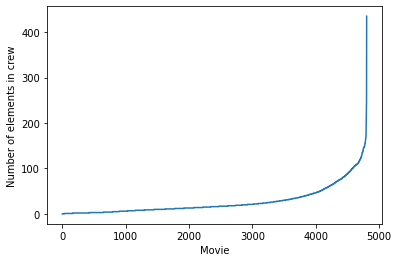

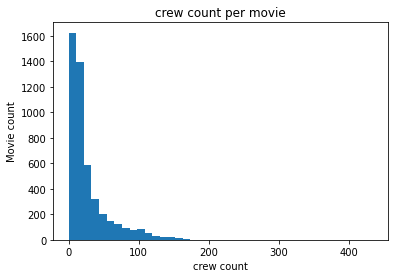


There are 28 movies with no elements in crew


In [278]:
check_object_column(df, "crew", "job", figsize=(15.3, 4.8), bins=40)

Check crew name

Found 52234 different unique elements
First elements:
[('Robert Rodriguez', 104), ('Steven Spielberg', 84), ('Avy Kaufman', 83), ('Mary Vernieu', 82), ('Deborah Aquila', 75), ('Hans Zimmer', 71), ('James Newton Howard', 69), ('Harvey Weinstein', 68), ('Tricia Wood', 67), ('Bob Weinstein', 67), ('Francine Maisler', 63), ('John Debney', 60), ('Danny Elfman', 58), ('Kerry Barden', 55), ('Kevin Kaska', 54), ('John Williams', 54), ('Christophe Beck', 54), ('Arnon Milchan', 54), ('Scott Rudin', 54), ('Luc Besson', 53)]
Last elements:
[('Kambuzia Partovi', 1), ('Jafar Panahi', 1), ('Colin Downey', 1), ('Daniel M. Berger', 1), ('Ladd Vance', 1), ('Orlando Aguillen', 1), ('Neill Dela Llana', 1), ('Ian Gamazon', 1), ('Eric Guthrie', 1), ('Chris Knudson', 1), ('Cecilio Rodríguez', 1), ('Mark Trujillo', 1), ('Harvey Kahn', 1), ('Adam Sliwinski', 1), ('Joel S. Rice', 1), ('Shana Landsburg', 1), ('Renee Read', 1), ('Lisa Binkley', 1), ('Brian Herzlinger', 1), ('Brett Winn', 1)]


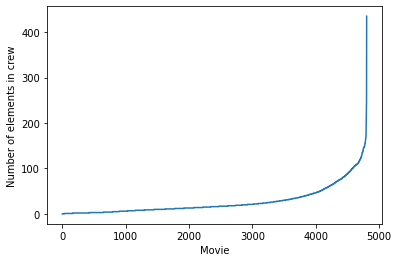

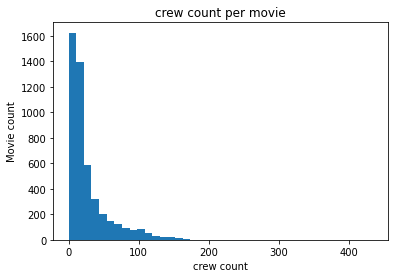


There are 28 movies with no elements in crew


In [279]:
check_object_column(df, "crew", "name", figsize=(15.3, 4.8), bins=40)

# Check columns left for missing values

In [280]:
def check_nan_values(df, column_name):
  nan_values_count = sum(df[column_name].isnull())
  print(f"Column {column_name} has {nan_values_count} NaN values")
  return nan_values_count

In [281]:
def check_empty_string(df, column_name):
  empty_string_count = 0
  for elem in list(df[column_name]):
    if elem == "":
      empty_string_count += 1
  print(f"Column {column_name} has {empty_string_count} empty string values")

Check homepage column

In [282]:
check_nan_values(df, "homepage")
check_empty_string(df, "homepage")

Column homepage has 3091 NaN values
Column homepage has 0 empty string values


Check overview column

In [283]:
check_nan_values(df, "overview")
check_empty_string(df, "overview")

Column overview has 3 NaN values
Column overview has 0 empty string values


Check release_date column

In [284]:
check_nan_values(df, "release_date")
check_empty_string(df, "release_date")

Column release_date has 1 NaN values
Column release_date has 0 empty string values


Check tagline column

In [285]:
check_nan_values(df, "tagline")
check_empty_string(df, "tagline")

Column tagline has 844 NaN values
Column tagline has 0 empty string values


# Useful vs Not useful columns for predicting genre



## Useful

*   Keywords

> 1.   There are 9813 unique keywords.
> 2.   412 movies with no keyword.
> 3.   Some keywords appear in many movies. The 1st ranked keyword appears in 324 movies, the 20th ranked keyword appears in 89 movies.


*   Title

> 1.   Any movies has a title.
> 2.   There are only 3 pairs of movies with the same title.


*   Overview

> 1.   **This might be the most useful feature**
> 2.   Only 3 movies have no overview.


*   Production Companies

> 1.   There are 5017 unique production companies.
> 2.   Some companies appear in many movies. The 1st ranked keyword appears in 319 movies, the 20th ranked keyword appears in 56 movies.
> 3.   351 movies have no production company stated.

*   Tagline

> 1.   844 movies have no tagline.
> 2.   They contain less information compared to **Overview** but the information should still be helpful.


## Maybe useful



*   Budget

> 1. 1037 movies have no budget reported.
> 2. There might be a link between the budget value and movie genre (ex: action movies might be generally more expensive)

*   Original Language

> 1. 4505 movies have English as original language.
> 2. All movies have exactly one original language reported.
> 3. It might be useful for predicting the genre for non US made movies. Other countries may be focusing on a particular movie genre.


*   Popularity

> 1. Only 1 movie has 0 popularity.
> 2. Popularity might be linked with movie genre (an educated guess would be that action movies have high popularity).

*   Production Countries

> 1. 174 movies have no production country reported.
> 2. US is connected to most movies (3956), however, some other countries are also connected to a decent amount of movies (the one ranked 20th is connected to 19 movies). 
> 3. Most movies have a single production country (\~3400), some movies have two production countries (\~800). Some movies have three production countries (\~250). There are even movies with six production countries.

*   Revenue

> 1. 1427 movies have no revenue reported.
> 2. Same as budget, there might be a link between movie genre and revenue.

*   Runtime

> 1. 35 movies have no runtime reported.
> 2. The runtime distribution is normal (almost) with mean of 100 minutes. 

*   Spoken Languages

> 1. 87 movies have no spoken language reported.
> 2. There are 86 unique spoken languages.
> 3. Similar to Production Countries

*   Vote Average

> 1. 63 movies with no vote average reported.
> 2. Normal distribution (almost) with mean of 6.

*   Vote Count

> 1. 62 movies have no vote count reported.
> 2. Exponential distribution, most movies have a low vote cound (75% less than 737 votes).

*   Cast

> 1. 43 movies have no cast members reported.
> 2. Some actors appear in multiple movies. The 1st actor appears in 67 movies, while the 20th ranked actor appears in 36 movies.
> 3. There are 54201 unique actors.
> 4. We could use the cast count as a feature. Maybe some movie genres generally use more actors than others.

*   Crew

> 1. 28 movies with no crew members reported.
> 2. Similarly to Cast, some crew members appear in multiple movies. 1st in 104 movies, 20th in 53 movies.
> 3. There are 52234 unique crew members.
> 4. There are only 12 unique crew departments. We could use the number of crew members from each department as a feature. Maybe some genres require additional crew members for a specific department.

## Useless



*   Homepage
*   Id
*   Status
*   Release Date

